### Necessarry Installs

In [1]:
! pip install dill
! pip install statsmodels
!pip install hurst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.6 MB/s eta 0:00:00


In [2]:
!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 4.4 MB/s eta 0:00:00


### Mount Gdrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Necessarry imports and Defined Functions

## Data Handling Functions

- **`save_pickle` and `load_pickle`**: Functions for saving and loading objects using LZMA compression and pickle.
- **`clean_data`**: Reindexes and merges close prices of tickers into a single DataFrame.
- **`get_data`**: Loads ticker data and returns a cleaned list of tickers and their corresponding dataframes.

## Analysis and Processing Functions

- **`get_pca_features`**: Computes PCA on returns DataFrame and standardizes the components.
- **`create_clusters`**: Uses DBSCAN to create clusters from the PCA features.
- **`find_cointegrated_pairs`**: Identifies pairs of stocks that are cointegrated.
- **`get_coint_pairs`**: Finds cointegrated pairs within clustered groups of stocks.

## Utility and Miscellaneous

- **`generate_trading_data_blocks`**: Generates trading data for a specified month and year.
- **`calculate_monthly_clusters`**: Calculates monthly clusters based on PCA of percentage changes in pricing data.
- **`yield_monthly_data`**: Generator function to yield monthly data for given years and months.


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from hurst import compute_Hc
from statsmodels.tools.tools import add_constant
from scipy.stats import skew, kurtosis
from scipy import stats
from statsmodels.tsa.stattools import adfuller as ADF_test

import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from tensorflow.keras.models import load_model


import lzma
import dill as pickle



def save_pickle(path,obj):
    with lzma.open(path,"wb") as fp:
        pickle.dump(obj,fp)

def load_pickle(path):
    with lzma.open(path,"rb") as fp:
        file = pickle.load(fp)
    return file

def clean_data(ticker_dfs,tickers):
    intraday_range = ticker_dfs[tickers[0]].index
    for inst in tickers:
        ticker_dfs[inst] = ticker_dfs[inst].reindex(intraday_range)
    closes = []

    for tk in tickers:
        close = ticker_dfs[tk].close
        closes.append(close)

    pricing = pd.concat(closes,axis = 1)
    pricing.columns = tickers

    return pricing




def get_pca_features(ret_df,N_PRIN_COMPONENTS =10):

    pca = PCA(n_components=N_PRIN_COMPONENTS)
    pca.fit(ret_df)

    # Extract factor loadings
    factor_loadings = pca.components_.T  # Transpose the components matrix

    # Create a DataFrame with the correct orientation
    factor_loadings_df = pd.DataFrame(factor_loadings, index=ret_df.columns, columns=[f'Factor {i+1}' for i in range(N_PRIN_COMPONENTS)])

    X = preprocessing.StandardScaler().fit_transform(pca.components_.T)

    return X

def create_clusters(X,index):
    clf = DBSCAN(eps=1.6, min_samples=3)

    print(clf)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("\nClusters discovered: %d" % n_clusters_)

    clustered = clf.labels_

    clustered_series = pd.Series(index=index, data=clustered.flatten())
    clustered_series = clustered_series[clustered_series != -1]

    return clustered_series


def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



def get_coint_pairs(prices,clustered_series):

    valid_tickers = clustered_series.index.intersection(prices.columns)
    clustered_series = clustered_series.loc[valid_tickers]

    CLUSTER_SIZE_LIMIT = 9999
    counts = clustered_series.value_counts()
    ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]

    cluster_dict = {}
    for i, which_clust in enumerate(ticker_count_reduced.index):
        tickers = clustered_series[clustered_series == which_clust].index
        score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
            prices[tickers]
        )
        cluster_dict[which_clust] = {}
        cluster_dict[which_clust]['score_matrix'] = score_matrix
        cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
        cluster_dict[which_clust]['pairs'] = pairs

    pairs = []
    for clust in cluster_dict.keys():
        pairs.extend(cluster_dict[clust]['pairs'])

    return pairs


def get_data():
    data_path = "/content/drive/My Drive/4. Pairs Trading Models/utils/constituents.csv"
    dfs_path = "/content/drive/My Drive/4. Pairs Trading Models/utils/new_dfs.obj"

    ticker_dfs = load_pickle(dfs_path)
    snp_data = pd.read_csv(data_path)
    tickers = []

    for i in range(499):
      tickers.append(snp_data.Symbol[i])

    tickers.remove("BF.B")
    tickers.remove("BRK.B")
    tickers.remove("CPAY")
    tickers.remove("DAY")
    tickers.remove("GEV")
    tickers.remove("SOLV")

    return tickers,ticker_dfs

In [5]:
def generate_trading_data_blocks(df, month, year):
    if month == 12:
        month = 1
        year += 1
    else:
        month += 1

    next_month_data = df[(df.index.year == year) & (df.index.month == month)]
    return next_month_data


def find_cointegrated_pairs(data):
    score_matrix = np.zeros((data.shape[1], data.shape[1]))
    pvalue_matrix = np.ones((data.shape[1], data.shape[1]))
    pairs = []

    for i in range(data.shape[1]):
        for j in range(i+1, data.shape[1]):
            result = sm.tsa.coint(data.iloc[:, i], data.iloc[:, j])
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:  # Cointegrated pair found
                pairs.append((data.columns[i], data.columns[j]))

    return score_matrix, pvalue_matrix, pairs


def calculate_monthly_clusters(monthly_data):
    """
    Calculate clusters for the given month.

    """
    ret_df = monthly_data.pct_change().round(4).fillna(0)
    X = get_pca_features(ret_df)
    clustered_series = create_clusters(X, ret_df.columns)

    return clustered_series

def yield_monthly_data(data):
    for (year, month), monthly_data in data.groupby([data.index.year, data.index.month]):
        yield year, month, monthly_data

### Load Data

In [6]:
tickers,ticker_dfs = get_data()
intraday_dfs = ticker_dfs.copy()
prices = clean_data(intraday_dfs, tickers)

In [7]:
def add_stationary(spread_normalized):

    rolling_volatility = spread_normalized[:500].rolling(window=10).std()
    hurst_exponent = compute_Hc(spread_normalized[:500])[0]  # Hurst exponent

    skewness = skew(spread_normalized[:500])
    kurtosis_value = kurtosis(spread_normalized[:500])


    # Ensure spread_lagged starts from the second element to align with spread_diff which starts from the second element due to differencing and shifting
    spread_lagged = spread_normalized.shift(1).dropna()
    spread_diff = spread_normalized.diff().dropna()  # First difference to get spread_diff

    # Make sure indices are aligned by reindexing spread_diff to match spread_lagged
    spread_diff = spread_diff.reindex(spread_lagged.index)
    spread_diff += 1e-8

    # Now perform your regression with aligned indices
    model = sm.OLS(np.log(np.abs(spread_diff)), add_constant(spread_lagged))
    result = model.fit()
    phi = result.params[0]


    spread_normalized = spread_normalized[:500]  # Normalized spread

    features_df = pd.DataFrame({
        'spread_normalized': spread_normalized,
        'rolling_volatility': rolling_volatility[:500],
        'hurst_exponent': np.repeat(hurst_exponent, rolling_volatility.shape[0]),
    })

    # Mean Reversion Speed calculated as the absolute value of phi
    mean_reversion_speed = np.abs(phi)

    # Calculate half-life from the decay factor
    half_life = -np.log(2) / np.log(np.abs(phi))


    features_df['half_life'] = np.repeat(half_life, len(features_df))
    features_df['mean_reversion_speed'] = np.repeat(mean_reversion_speed, len(features_df))
    features_df['skewness'] = np.repeat(skewness, len(features_df))
    features_df['kurtosis'] = np.repeat(kurtosis_value, len(features_df))

    return features_df




def process_pair(pair, prices):
    s1, s2 = pair

    datax = prices[s1]
    datay = prices[s2]

    # Calculate hedge ratio using the first 500 data points
    hedge_ratio = sm.OLS(datax[:500], sm.add_constant(datay[:500])).fit().params[1]

    # Calculate the spread based on the hedge ratio
    spread = datax - hedge_ratio * datay

    # Calculate mean and standard deviation using the first 500 data points
    initial_mean = spread[:500].mean()
    initial_std = spread[:500].std()

    # Create a DataFrame with the calculated columns
    df = pd.DataFrame({
        'datax': datax,
        'datay': datay,
        'hedge_ratio': hedge_ratio,
        'spread': spread,
        'rolling_mean': initial_mean,
        'rolling_std': initial_std
    })

    # Normalized spread
    spread_normalized = (spread - initial_mean) / initial_std

    # Plotting the normalized spread along with mean and ±2 std lines
    plt.figure(figsize=(15, 7))
    spread_normalized = spread_normalized.reset_index(drop=True)
    plt.title(f'Z-Scores for {s1} and {s2} Across Training Period')
    spread_normalized.plot(label='Normalized Spread')
    plt.axhline(y=0, color='black', linestyle='--', label='Mean')
    plt.axhline(y=2, color='red', linestyle='--', label='+2 Std Dev')
    plt.axhline(y=-2, color='green', linestyle='--', label='-2 Std Dev')
    plt.legend()
    plt.show()

    return df


def calculate_hedge_ratio(x, y):
    x = sm.add_constant(x)  # Adding a constant term for the intercept
    model = sm.OLS(y, x).fit()
    return model.params[1]  # Return

def process_pair(pair, prices, window=100):
    s1, s2 = pair
    datax = prices[s1]
    datay = prices[s2]

    hedge_ratios = []
    for start in range(len(datax) - window + 1):
        end = start + window
        x_window = datax[start:end]
        y_window = datay[start:end]
        hedge_ratio = calculate_hedge_ratio(x_window, y_window)
        hedge_ratios.append(hedge_ratio)

    hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
    hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

    spread = datax - hedge_ratios * datay
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()
    upper_threshold_level = rolling_mean + 2 * rolling_std
    lower_threshold_level = rolling_mean - 2 * rolling_std

    # Calculate spread
    spread = datax - hedge_ratios * datay

    # Calculate rolling mean and rolling standard deviation
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    # Calculate upper and lower threshold levels
    upper_threshold_level = rolling_mean + 2 * rolling_std
    lower_threshold_level = rolling_mean - 2 * rolling_std

    # Create DataFrame
    result_df = pd.DataFrame({
        's1': datax,
        's2': datay,
        'spread': spread,
        'hedge_ratios': hedge_ratios,
        'rolling_mean': rolling_mean,
        'upper_threshold_level': upper_threshold_level,
        'lower_threshold_level': lower_threshold_level
    })

    return result_df

#### `add_stationary(spread_normalized)`
Calculates various financial statistics for a normalized spread including rolling volatility, Hurst exponent, skewness, kurtosis, and performs a regression to determine the mean reversion speed and half-life of the series. Returns a DataFrame with these metrics.

#### `process_pair(pair, prices)`
Processes a pair of stock tickers to calculate the hedge ratio and normalize the spread between them using the first 500 data points. Generates a plot of the normalized spread along with its mean and ±2 standard deviations. Returns a DataFrame with the spread and its statistics.

#### `calculate_hedge_ratio(x, y)`
Calculates and returns the hedge ratio between two series using linear regression.

#### `process_pair(pair, prices, window=100)`
Processes a pair of stock tickers over a sliding window to dynamically calculate hedge ratios and related trading statistics like rolling mean and standard deviations. Returns a DataFrame with detailed trading metrics.


### Backtesting Framework Classes and Functions

In [8]:
class Backtest:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.per_pair_capital = initial_capital

    def process_pair(self, pair, prices, window=100):
        raise NotImplementedError("Subclasses should implement this method")

    def trade(self, result_df):
        capital = self.initial_capital
        positions = 0
        entry_spread = 0
        entry_s1 = 0
        entry_s2 = 0
        entry_qty_s1 = 0
        entry_qty_s2 = 0
        last_capital_update_index = 0
        stop_loss_threshold = 0.01  # 1% stop loss

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = capital
        result_df['cap_ret'] = 0.0

        trades = []

        for i in range(1, len(result_df)):  # Start from the second row
            if i > last_capital_update_index:
                result_df.loc[result_df.index[last_capital_update_index:i], 'capital'] = capital

            # Calculate the required capital to trade one pair
            hedge_ratio = abs(result_df['hedge_ratios'].iloc[i])
            required_capital_per_pair = (result_df['s1'].iloc[i] + hedge_ratio * result_df['s2'].iloc[i])

            # Calculate the maximum quantity that can be traded based on available capital
            max_qty = self.per_pair_capital // required_capital_per_pair

            if positions == 0:
                if result_df['spread'].iloc[i] > result_df['upper_threshold_level'].iloc[i]:
                    positions = -1  # Sell position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Sell'
                    trades.append(result_df.iloc[i].copy())
                    last_capital_update_index = i
                elif result_df['spread'].iloc[i] < result_df['lower_threshold_level'].iloc[i]:
                    positions = 1  # Buy position
                    entry_spread = result_df['spread'].iloc[i]
                    entry_s1 = result_df['s1'].iloc[i]
                    entry_s2 = result_df['s2'].iloc[i]
                    entry_qty_s1 = max_qty
                    entry_qty_s2 = max_qty * hedge_ratio
                    result_df.at[result_df.index[i], 'action'] = 'Buy'
                    trades.append(result_df.iloc[i].copy())
                    last_capital_update_index = i

            elif positions == -1:
                if result_df['spread'].iloc[i] <= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for sell position
                    returns = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) -
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / ((entry_s1*entry_qty_s1) + (entry_s2 *entry_qty_s2 ))
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Sell'
                    positions = 0  # Close position
                    last_capital_update_index = i
                    trades.append(result_df.iloc[i].copy())
                else:
                    # Check stop loss for sell position
                    loss = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / ((entry_s1*entry_qty_s1) + (entry_s2 *entry_qty_s2 ))
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Sell'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i
                        trades.append(result_df.iloc[i].copy())

            elif positions == 1:
                if result_df['spread'].iloc[i] >= result_df['rolling_mean'].iloc[i]:
                    # Calculate returns for buy position
                    returns = (entry_qty_s1 * (result_df['s1'].iloc[i] - entry_s1) +
                               entry_qty_s2 * (result_df['s2'].iloc[i] - entry_s2))
                    returns_pct = returns / ((entry_s1*entry_qty_s1) + (entry_s2 *entry_qty_s2 ))
                    capital += returns
                    result_df.at[result_df.index[i], 'returns'] = returns
                    result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                    result_df.at[result_df.index[i], 'capital'] = capital
                    result_df.at[result_df.index[i], 'action'] = 'Close Buy'
                    positions = 0  # Close position
                    last_capital_update_index = i
                    trades.append(result_df.iloc[i].copy())
                else:
                    # Check stop loss for buy position
                    loss = (entry_qty_s1 * (entry_s1 - result_df['s1'].iloc[i]) +
                            entry_qty_s2 * (entry_s2 - result_df['s2'].iloc[i]))
                    if loss >= stop_loss_threshold * self.per_pair_capital:
                        capital -= loss
                        returns_pct = -loss / ((entry_s1*entry_qty_s1) + (entry_s2 *entry_qty_s2 ))
                        result_df.at[result_df.index[i], 'returns'] = -loss
                        result_df.at[result_df.index[i], 'returns_pct'] = returns_pct
                        result_df.at[result_df.index[i], 'capital'] = capital
                        result_df.at[result_df.index[i], 'action'] = 'Stop Loss Buy'
                        positions = 0  # Close position due to stop loss
                        last_capital_update_index = i
                        trades.append(result_df.iloc[i].copy())

            # Update capital for the remaining rows
            result_df.loc[result_df.index[last_capital_update_index:], 'capital'] = capital


        trades_df = pd.DataFrame(trades)
        return result_df, trades_df

    def visualize_spread(self, result_df):
        plt.figure(figsize=(14, 7))

        result_df.reset_index(inplace = True)

        plt.plot(result_df.index, result_df['spread'], label='Spread')
        plt.plot(result_df.index, result_df['rolling_mean'], label='Rolling Mean', linestyle='--')
        plt.plot(result_df.index, result_df['upper_threshold_level'], label='Upper Threshold', linestyle='--')
        plt.plot(result_df.index, result_df['lower_threshold_level'], label='Lower Threshold', linestyle='--')

        plt.fill_between(result_df.index, result_df['upper_threshold_level'], result_df['lower_threshold_level'], color='grey', alpha=0.3)

        # Add markers for actions
        buys = result_df[result_df['action'] == 'Buy']
        sells = result_df[result_df['action'] == 'Sell']
        close_buys = result_df[result_df['action'] == 'Close Buy']
        close_sells = result_df[result_df['action'] == 'Close Sell']

        plt.scatter(buys.index, buys['spread'] + 0.02, color='green', marker='^', s=100, label='Buy')  # Offset buys
        plt.scatter(sells.index, sells['spread'] - 0.02, color='red', marker='v', s=100, label='Sell')  # Offset sells
        plt.scatter(close_buys.index, close_buys['spread'], color='black', marker='o', s=100, label='Close Buy')
        plt.scatter(close_sells.index, close_sells['spread'], color='black', marker='x', s=100, label='Close Sell')

        plt.title('Spread with Rolling Mean and Threshold Levels')
        plt.xlabel('Time')
        plt.ylabel('Spread')
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_metrics(self, combined_trades_df):
        if combined_trades_df.empty:
            return None

        # Filter out the rows where trades were closed
        closed_trades = combined_trades_df[combined_trades_df['action'].isin(['Close Buy', 'Close Sell', 'Stop Loss Buy', 'Stop Loss Sell'])]


        metrics = {
            'Average Trade Return': 0,
            'Standard Deviation of Trade Returns': 0,
            'Sharpe Ratio': 0,
            'No. of trades': 0
        }

        if closed_trades.empty:
            return metrics

        # Calculate the returns on closed trades
        trade_returns = closed_trades['returns_pct']

        # Calculate the average return per trade
        avg_trade_return = trade_returns.mean()

        # Calculate the standard deviation of returns per trade
        std_trade_return = trade_returns.std()

        # Calculate the Sharpe ratio
        if std_trade_return != 0:
            sharpe_ratio = (avg_trade_return / std_trade_return) * np.sqrt(252)  # Assuming 252 trading days in a year
        else:
            sharpe_ratio = 0

        # Calculate cumulative returns
        cumulative_return = 0

        metrics = {
            'Average Trade Return': avg_trade_return,
            'Standard Deviation of Trade Returns': std_trade_return,
            'Sharpe Ratio': sharpe_ratio,
            'No. of trades': len(closed_trades)
        }

        return metrics


In [9]:
class BacktestOLS(Backtest):
    def __init__(self, initial_capital=100000):
        super().__init__(initial_capital)

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]  # Return the coefficient of x, which is the hedge ratio

    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        hedge_ratios = []
        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            hedge_ratios.append(hedge_ratio)

        hedge_ratios = pd.Series(hedge_ratios, index=datax.index[window-1:])
        hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

        spread = datax - hedge_ratios * datay

        spread_normalized = (spread - spread.mean()) / spread.std()
        adf_result_train = ADF_test(spread_normalized[:100])

        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        result_df = pd.DataFrame({
            's1': datax,
            's2': datay,
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan
        result_df['pair'] = f"{s1}/{s2}"

        return result_df

class BacktestKalman(Backtest):
    def __init__(self, initial_capital=100000, delta=1e-5):
        super().__init__(initial_capital)
        self.delta = delta

    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        # Standardize the data
        datax = (datax - datax.mean()) / datax.std()
        datay = (datay - datay.mean()) / datay.std()

        # Initialize Kalman filter for dynamic hedge ratio
        trans_cov = self.delta / (1 - self.delta) * np.eye(2)  # State transition covariance
        kf = KalmanFilter(
            transition_matrices=np.eye(2),
            observation_matrices=np.vstack([datax, np.ones(len(datax))]).T[:, np.newaxis],
            initial_state_mean=np.zeros(2),
            initial_state_covariance=np.ones((2, 2)),
            observation_covariance=1,
            transition_covariance=trans_cov
        )

        state_means, _ = kf.filter(datay.values)
        hedge_ratios = pd.Series(state_means[:, 0], index=datay.index)

        spread = datax - hedge_ratios * datay

        spread_normalized = (spread - spread.mean()) / spread.std()
        adf_result_train = ADF_test(spread_normalized[:100])


        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        result_df = pd.DataFrame({
            's1': prices[s1],
            's2': prices[s2],
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan
        result_df['pair'] = f"{s1}/{s2}"

        return result_df




class Backtest_model(Backtest):
    def __init__(self, initial_capital=100000, model=None):
        super().__init__(initial_capital)
        self.model = model  # Pre-trained model for predicting hedge ratios

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]

    def add_stationary_features(self, spread_normalized):
        rolling_volatility = spread_normalized.rolling(window=10).std()
        hurst_exponent = compute_Hc(spread_normalized)[0]  # Hurst exponent
        skewness = skew(spread_normalized)
        kurtosis_value = kurtosis(spread_normalized)

        spread_lagged = spread_normalized.shift(1).dropna()
        spread_diff = spread_normalized.diff().dropna()
        spread_diff = spread_diff.reindex(spread_lagged.index)
        spread_diff += 1e-8

        model = sm.OLS(np.log(np.abs(spread_diff)), sm.add_constant(spread_lagged))
        result = model.fit()
        phi = result.params[0]

        mean_reversion_speed = np.abs(phi)
        half_life = -np.log(2) / np.log(np.abs(phi))

        features_df = pd.DataFrame({
            'spread_normalized': spread_normalized,
            'rolling_volatility': rolling_volatility,
            'hurst_exponent': np.repeat(hurst_exponent, len(spread_normalized)),
            'half_life': np.repeat(half_life, len(spread_normalized)),
            'mean_reversion_speed': np.repeat(mean_reversion_speed, len(spread_normalized)),
            'skewness': np.repeat(skewness, len(spread_normalized)),
            'kurtosis': np.repeat(kurtosis_value, len(spread_normalized))
        })

        features_df.dropna(inplace=True)
        return features_df

    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        hedge_ratios = []
        feature_arrays = []

        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]

            spread = x_window - self.calculate_hedge_ratio(x_window, y_window) * y_window
            spread_normalized = (spread - spread.mean()) / spread.std()
            features_df = self.add_stationary_features(spread_normalized)
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            features_df['hedge_ratio'] = np.repeat(hedge_ratio, len(features_df))
            feature_arrays.append(features_df.values)

        # Convert list of arrays to a 3D numpy array
        feature_arrays = np.array(feature_arrays)

        # Make predictions using the pre-trained model
        predicted_hedge_ratios = self.model.predict(feature_arrays)

        hedge_ratios = pd.Series(predicted_hedge_ratios.flatten(), index=datax.index[window-1:])
        hedge_ratios = hedge_ratios.reindex(datax.index).fillna(method='bfill')

        spread = datax - hedge_ratios * datay
        rolling_mean = spread.rolling(window=window).mean()
        rolling_std = spread.rolling(window=window).std()
        upper_threshold_level = rolling_mean + 2 * rolling_std
        lower_threshold_level = rolling_mean - 2 * rolling_std

        # Ensure rolling calculations do not start with NaN values
        rolling_mean = rolling_mean.fillna(method='bfill')
        rolling_std = rolling_std.fillna(method='bfill')
        upper_threshold_level = upper_threshold_level.fillna(method='bfill')
        lower_threshold_level = lower_threshold_level.fillna(method='bfill')

        result_df = pd.DataFrame({
            's1': datax,
            's2': datay,
            'spread': spread,
            'hedge_ratios': hedge_ratios,
            'rolling_mean': rolling_mean,
            'upper_threshold_level': upper_threshold_level,
            'lower_threshold_level': lower_threshold_level
        })

        result_df['returns'] = 0.0
        result_df['returns_pct'] = 0.0
        result_df['capital'] = self.initial_capital
        result_df['action'] = np.nan
        result_df['pair'] = f"{s1}/{s2}"

        return result_df


#### `Backtest`
- A base class for creating backtest simulations.
- Includes method stubs for processing a pair of stocks and trading based on a dataframe of results.

#### `BacktestOLS`
- Inherits from `Backtest`.
- Implements an OLS-based approach to calculate hedge ratios and process trading pairs over a rolling window.

#### `BacktestKalman`
- Inherits from `Backtest`.
- Utilizes a Kalman Filter to dynamically adjust hedge ratios for a pair of stocks over a rolling window.

#### `Backtest_model`
- Inherits from `Backtest`.
- Uses a pre-trained model to predict hedge ratios and incorporates stationary features like Hurst exponent and kurtosis into the trading logic.

#### `Classification_model`
- Inherits from `Backtest`.
- Uses a classification model to predict if the spread is stationary and adjusts trading actions based on the model's predictions.

#### `adjust_trades_based_on_predictions(trades_df, predictions)`
- Adjusts trades based on predictions from a classification model to determine valid trading actions.


In [10]:
class Classification_model(Backtest):
    def __init__(self, initial_capital=100000, model=None):
        super().__init__(initial_capital)
        self.classification_model = model  # Pre-trained classification model

    def calculate_hedge_ratio(self, x, y):
        x = sm.add_constant(x)  # Adding a constant term for the intercept
        model = sm.OLS(y, x).fit()
        return model.params[1]  # Return the coefficient of x, which is the hedge ratio

    def add_stationary_features(self, spread_normalized):
        rolling_volatility = spread_normalized.rolling(window=10).std()
        hurst_exponent = compute_Hc(spread_normalized)[0]  # Hurst exponent
        skewness = skew(spread_normalized)
        kurtosis_value = kurtosis(spread_normalized)

        spread_lagged = spread_normalized.shift(1).dropna()
        spread_diff = spread_normalized.diff().dropna()
        spread_diff = spread_diff.reindex(spread_lagged.index)
        spread_diff += 1e-8

        model = sm.OLS(np.log(np.abs(spread_diff)), sm.add_constant(spread_lagged))
        result = model.fit()
        phi = result.params[0]

        mean_reversion_speed = np.abs(phi)
        half_life = -np.log(2) / np.log(np.abs(phi))

        features_df = pd.DataFrame({
            'spread_normalized': spread_normalized,
            'rolling_volatility': rolling_volatility,
            'hurst_exponent': np.repeat(hurst_exponent, len(spread_normalized)),
            'half_life': np.repeat(half_life, len(spread_normalized)),
            'mean_reversion_speed': np.repeat(mean_reversion_speed, len(spread_normalized)),
            'skewness': np.repeat(skewness, len(spread_normalized)),
            'kurtosis': np.repeat(kurtosis_value, len(spread_normalized))
        })

        features_df.dropna(inplace=True)
        return features_df

    def process_pair(self, pair, prices, window=100):
        s1, s2 = pair
        datax = prices[s1]
        datay = prices[s2]

        predictions = []
        feature_arrays = []


        for start in range(len(datax) - window + 1):
            end = start + window
            x_window = datax[start:end]
            y_window = datay[start:end]

            spread = x_window - self.calculate_hedge_ratio(x_window, y_window) * y_window
            spread_normalized = (spread - spread.mean()) / spread.std()
            features_df = self.add_stationary_features(spread_normalized)
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)
            features_df['hedge_ratio'] = np.repeat(hedge_ratio, len(features_df))
            feature_arrays.append(features_df.values)
            hedge_ratio = self.calculate_hedge_ratio(x_window, y_window)


        # Convert list of arrays to a 3D numpy array
        feature_arrays = np.array(feature_arrays)

        # Predict whether the spread is stationary
        predictions = (self.classification_model.predict(feature_arrays) > 0.7).astype(int)
        predictions = predictions.flatten()
        predictions = pd.Series(predictions, index=datax.index[window-1:]).reindex(datax.index).fillna(method='bfill')

        return predictions

In [12]:
def adjust_trades_based_on_predictions(trades_df, predictions):
    adjusted_trades_df = trades_df.copy()
    for idx in range(len(adjusted_trades_df)):
        row = adjusted_trades_df.iloc[idx]
        date = row.name
        if predictions.get(date, 1) == 0:
            if row['action'] in ['Buy', 'Sell']:
                adjusted_trades_df.at[date, 'action'] = 'Invalid ' + row['action']
                exit_idx = idx + 1
                if exit_idx < len(adjusted_trades_df):
                    exit_row = adjusted_trades_df.iloc[exit_idx]
                    adjusted_trades_df.at[exit_row.name, 'action'] = 'Invalid ' + exit_row['action']

    initial_capital = trades_df['capital'].iloc[0]
    running_capital = initial_capital
    for idx in range(len(adjusted_trades_df)):
        row = adjusted_trades_df.iloc[idx]
        if 'Invalid' not in row['action']:
            running_capital += row['returns']
        adjusted_trades_df.at[row.name, 'capital'] = running_capital

    return adjusted_trades_df

### Actual Run Models for different Period

In [13]:
def run_combined_backtest(data):

    # Assuming 'data' has a date index or a date column
    if not data.empty :
        latest_date = data.index.max()
        last_year, last_month = latest_date.year, latest_date.month
    else:
        # Default to some reasonable values or handle the empty case
        last_year, last_month = 2023, 12  # This can be adjusted or handled if data is empty

    master_combined_trades_df_OLS = pd.DataFrame()
    master_combined_trades_adj_df_OLS = pd.DataFrame()
    master_combined_trades_df_Kalman = pd.DataFrame()
    master_combined_trades_adj_df_Kalman = pd.DataFrame()

    print(last_month, last_year)


    for year, month, monthly_data in yield_monthly_data(data):
        if month == last_month and year == last_year:
            print(f"Reached the end of available data at {month} {year}")
            break

        print(f"Clustering for {month} {year}")
        cluster = calculate_monthly_clusters(monthly_data)
        data = data.dropna(axis=1)
        next_month_data = generate_trading_data_blocks(data, month, year)
        pairs = get_coint_pairs(next_month_data[:500], cluster)

        combined_trades_df_OLS = pd.DataFrame()
        combined_trades_adj_df_OLS = pd.DataFrame()
        combined_trades_df_Kalman = pd.DataFrame()
        combined_trades_adj_df_Kalman = pd.DataFrame()

        for i, pair in enumerate(pairs):
            print(f"Processing pair: {pair}")

            # OLS Model
            agent_OLS = BacktestOLS()
            result_df_OLS = agent_OLS.process_pair(pair, next_month_data[100:])
            result_df_OLS, trades_df_OLS = agent_OLS.trade(result_df_OLS)
            combined_trades_df_OLS = pd.concat([combined_trades_df_OLS, trades_df_OLS])

            # Adjust OLS trades

            # Process the pair with the classification model and adjust trades
            agent_CLF = Classification_model(model=model)
            predictions = agent_CLF.process_pair(pair, next_month_data[100:])
            adj_trades_df_OLS = adjust_trades_based_on_predictions(trades_df_OLS, predictions)
            combined_trades_adj_df_OLS = pd.concat([combined_trades_adj_df_OLS, adj_trades_df_OLS])

            # Kalman Model
            agent_Kalman = BacktestKalman()
            result_df_Kalman = agent_Kalman.process_pair(pair, next_month_data[100:])
            result_df_Kalman, trades_df_Kalman = agent_Kalman.trade(result_df_Kalman)
            combined_trades_df_Kalman = pd.concat([combined_trades_df_Kalman, trades_df_Kalman])

            # Adjust Kalman trades
            adj_trades_df_Kalman = adjust_trades_based_on_predictions(trades_df_Kalman, predictions)
            combined_trades_adj_df_Kalman = pd.concat([combined_trades_adj_df_Kalman, adj_trades_df_Kalman])

        # Store combined monthly results
        master_combined_trades_df_OLS = pd.concat([master_combined_trades_df_OLS, combined_trades_df_OLS])
        master_combined_trades_adj_df_OLS = pd.concat([master_combined_trades_adj_df_OLS, combined_trades_adj_df_OLS])
        master_combined_trades_df_Kalman = pd.concat([master_combined_trades_df_Kalman, combined_trades_df_Kalman])
        master_combined_trades_adj_df_Kalman = pd.concat([master_combined_trades_adj_df_Kalman, combined_trades_adj_df_Kalman])

    # Return all results for further analysis or reporting
    return {
        "OLS": master_combined_trades_df_OLS,
        "Adj OLS": master_combined_trades_adj_df_OLS,
        "Kalman": master_combined_trades_df_Kalman,
        "Adj Kalman": master_combined_trades_adj_df_Kalman
    }


#### `run_combined_backtest(data)`
This function performs a comprehensive backtesting process using two different models: Ordinary Least Squares (OLS) and Kalman Filter, on a dataset that presumably contains financial price data indexed by date. The function also incorporates predictions from a classification model to adjust trading strategies based on the stationary nature of the spread.

#### Steps and Processes:

1. **Initialization**:
   - Checks if the provided data is empty and initializes variables to track the end date of the dataset.

2. **Loop through monthly data**:
   - Utilizes `yield_monthly_data(data)` to iterate over each month's data.
   - Clusters data monthly using `calculate_monthly_clusters(monthly_data)`.
   - Generates trading blocks for the subsequent month using `generate_trading_data_blocks(data, month, year)`.

3. **Pair Processing**:
   - Identifies cointegrated pairs within the clustered data using `get_coint_pairs(next_month_data[:500], cluster)`.
   - Processes each pair for both OLS and Kalman strategies.
   - Each model processes the pairs and performs trading actions, which are then captured in a DataFrame.

4. **Trade Adjustment**:
   - Adjusts trades based on predictions from a classification model (`Classification_model`) using `adjust_trades_based_on_predictions(trades_df, predictions)`.
   - This adjustment is intended to account for non-stationary conditions in the spread, potentially improving the robustness of the trading strategy.

5. **Results Compilation**:
   - Aggregates results from all months and both models into master DataFrames.
   - Separate DataFrames are maintained for adjusted and non-adjusted trade results.

6. **Return Value**:
   - The function returns a dictionary containing DataFrames for all trade results: raw and adjusted, for both OLS and Kalman models.


#### Execution

In [14]:
#execute

model_path = "/content/drive/My Drive/4. Pairs Trading Models/Model/stationary_check_model.h5"
model = load_model(model_path)

data1 = prices[-10000:-5000]
data2 = prices[-5000:]
data3 = prices[-10000:]

# Run the combined backtest
results_1 = run_combined_backtest(data1)
results_2 = run_combined_backtest(data2)
results_3 = run_combined_backtest(data3)


9 2023
Clustering for 6 2023
DBSCAN(eps=1.6, min_samples=3)

Clusters discovered: 3
Processing pair: ('AMZN', 'DIS')
43/43 [==============================] - 3s 28ms/step
Processing pair: ('XOM', 'TGT')
43/43 [==============================] - 1s 18ms/step
Clustering for 7 2023
DBSCAN(eps=1.6, min_samples=3)

Clusters discovered: 3
Processing pair: ('BAC', 'JPM')
50/50 [==============================] - 1s 27ms/step
Processing pair: ('COST', 'XOM')
50/50 [==============================] - 1s 19ms/step
Processing pair: ('PFE', 'WBA')
50/50 [==============================] - 1s 22ms/step
Clustering for 8 2023
DBSCAN(eps=1.6, min_samples=3)

Clusters discovered: 4
Processing pair: ('AAL', 'META')
40/40 [==============================] - 2s 43ms/step
Processing pair: ('AAPL', 'SBUX')
40/40 [==============================] - 1s 20ms/step
Processing pair: ('T', 'MSFT')
40/40 [==============================] - 1s 21ms/step
Processing pair: ('DAL', 'META')
40/40 [==============================

### Compare Models on Different Parameters

In [15]:
def calculate_metrics(combined_trades_df, period=252):
    if combined_trades_df.empty:
        return None

    # Filter out the rows where trades were closed
    closed_trades = combined_trades_df[combined_trades_df['action'].isin(['Close Buy', 'Close Sell', 'Stop Loss Buy', 'Stop Loss Sell'])]

    if closed_trades.empty:
        return {
            'Average Trade Return': 0,
            'Standard Deviation of Trade Returns': 0,
            'Sharpe Ratio': 0,
            'No. of trades': 0,
            'Cumulative Return': 0,
            'Max Drawdown': 0
        }

    # Calculate the returns on closed trades
    trade_returns = closed_trades['returns_pct']

    # Calculate the average return per trade
    avg_trade_return = trade_returns.mean()

    # Calculate the standard deviation of returns per trade
    std_trade_return = trade_returns.std()

    # Calculate the Sharpe ratio
    if std_trade_return != 0:
        sharpe_ratio = (avg_trade_return / std_trade_return) * np.sqrt(period)  # Assuming 'period' trading days in a year
    else:
        sharpe_ratio = 0

    # Calculate cumulative returns and logarithmic returns
    cumulative_returns = np.cumprod(1 + trade_returns)
    logarithmic_returns = np.log(cumulative_returns)

    # Calculate the rolling drawdown
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()  # Most negative drawdown

    metrics = {
        'Average Trade Return': avg_trade_return,
        'Standard Deviation of Trade Returns': std_trade_return,
        'Sharpe Ratio': sharpe_ratio,
        'No. of trades': len(closed_trades),
        'Cumulative Return': cumulative_returns.iloc[-1] if not cumulative_returns.empty else 0,
        'Max Drawdown': max_drawdown
    }

    return metrics



#### `calculate_metrics(combined_trades_df, period=252)`
Calculates and returns key performance metrics for a set of trading results, including:
- Average Trade Return
- Standard Deviation of Trade Returns
- Sharpe Ratio
- Number of Trades
- Cumulative Return
- Maximum Drawdown
These metrics provide a comprehensive overview of the trading strategy's performance.

#### `precompute_metrics(results)`
Takes the results from a trading period and computes the key metrics using `calculate_metrics`. Returns a dictionary with metrics like Sharpe Ratio, Max Drawdown, Number of Trades, and Cumulative Return. This function simplifies the process of evaluating and comparing the performance of different trading strategies or models over multiple periods.


In [16]:
def precompute_metrics(results):
    # This function takes in the results for a model and returns a dictionary of metrics
    metrics = calculate_metrics(results)
    return {
        "Sharpe Ratio": metrics["Sharpe Ratio"],
        "Max Drawdown": metrics["Max Drawdown"],
        "No. of Trades": (metrics["No. of trades"]),
        "Cumulative Return": metrics["Cumulative Return"],
    }

# Assume results_1, results_2, results_3 contain results for each period and model
results = {
    "Period 1": {
        "OLS": precompute_metrics(results_1["OLS"]),
        "Adj OLS": precompute_metrics(results_1["Adj OLS"]),
        "Kalman": precompute_metrics(results_1["Kalman"]),
        "Adj Kalman": precompute_metrics(results_1["Adj Kalman"])
    },
    "Period 2": {
        "OLS": precompute_metrics(results_2["OLS"]),
        "Adj OLS": precompute_metrics(results_2["Adj OLS"]),
        "Kalman": precompute_metrics(results_2["Kalman"]),
        "Adj Kalman": precompute_metrics(results_2["Adj Kalman"])
    },
    "Period 3": {
        "OLS": precompute_metrics(results_3["OLS"]),
        "Adj OLS": precompute_metrics(results_3["Adj OLS"]),
        "Kalman": precompute_metrics(results_3["Kalman"]),
        "Adj Kalman": precompute_metrics(results_3["Adj Kalman"])
    }
}



#### Sharpe Ratios

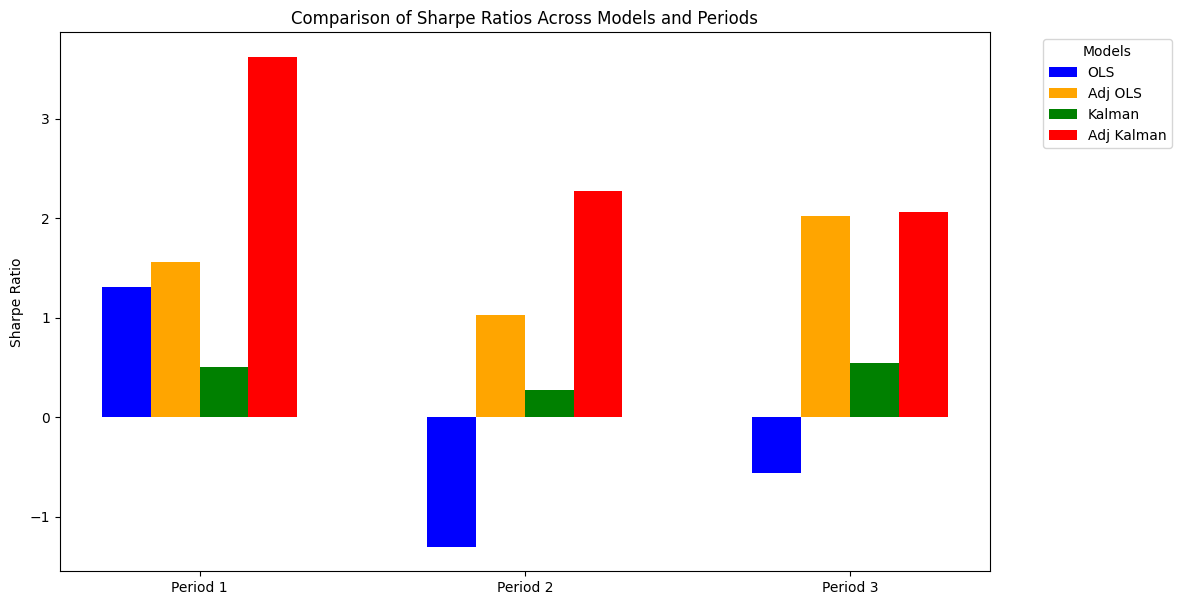

In [17]:
periods = ["Period 1", "Period 2", "Period 3"]
models = ["OLS", "Adj OLS", "Kalman", "Adj Kalman"]
colors = ['blue', 'orange', 'green', 'red']

fig, ax = plt.subplots(figsize=(12, 7))  # Adjusted for a better aspect ratio
width = 0.15  # Narrower bars for a more refined look

for i, period in enumerate(periods):
    offsets = [-1.5 * width, -0.5 * width, 0.5 * width, 1.5 * width]
    for j, model in enumerate(models):
        sharpe_ratio = results[period][model]["Sharpe Ratio"]
        ax.bar(i + offsets[j], sharpe_ratio, width, color=colors[j], label=model if i == 0 else "")

ax.set_ylabel('Sharpe Ratio')
ax.set_title('Comparison of Sharpe Ratios Across Models and Periods')
ax.set_xticks(range(len(periods)))
ax.set_xticklabels(periods)
ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


#### Max Drawdown

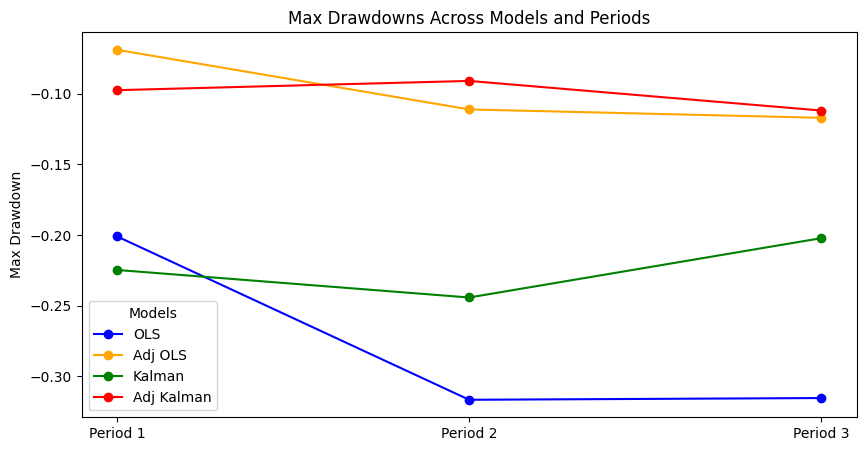

In [18]:
periods = ["Period 1", "Period 2", "Period 3"]
models = ["OLS", "Adj OLS", "Kalman", "Adj Kalman"]
colors = ['blue', 'orange', 'green', 'red']

fig, ax = plt.subplots(figsize=(10, 5))  # Create a figure for the Max Drawdown plot

# Plotting Max Drawdown with a line plot
for j, model in enumerate(models):
    max_drawdowns = [results[period][model]["Max Drawdown"] for period in periods]
    ax.plot(periods, max_drawdowns, marker='o', color=colors[j], label=model)

ax.set_ylabel('Max Drawdown')
ax.set_title('Max Drawdowns Across Models and Periods')
ax.legend(title='Models')

plt.show()


#### Number of Trades vs Sharpe Ratio

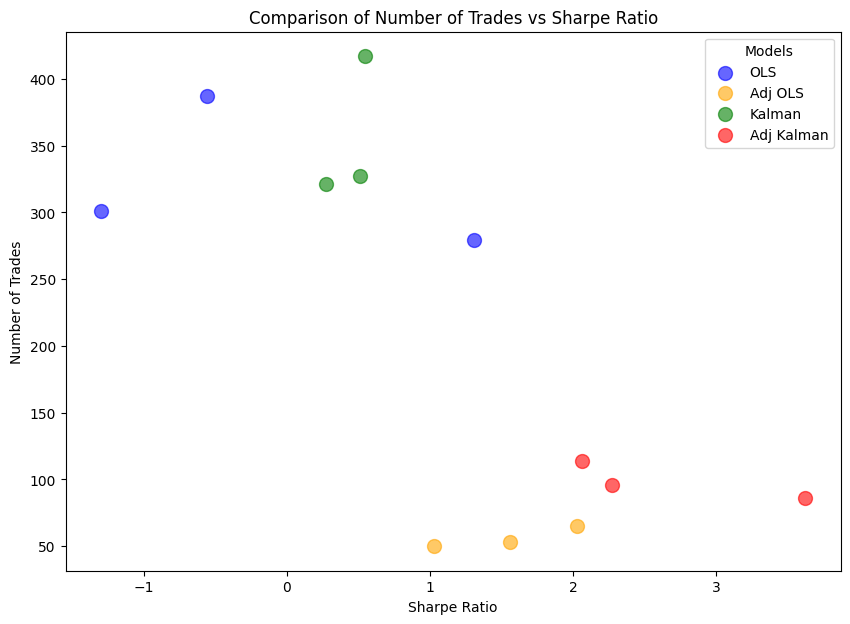

In [19]:
periods = ["Period 1", "Period 2", "Period 3"]
models = ["OLS", "Adj OLS", "Kalman", "Adj Kalman"]
colors = ['blue', 'orange', 'green', 'red']  # Fixed colors for each model

fig, ax = plt.subplots(figsize=(10, 7))  # Create a larger figure for clarity

for i, model in enumerate(models):
    sharpe_ratios = [results[period][model]["Sharpe Ratio"] for period in periods]
    num_trades = [results[period][model]["No. of Trades"] for period in periods]
    ax.scatter(sharpe_ratios, num_trades, color=colors[i], s=100, label=model, alpha=0.6)

ax.set_xlabel('Sharpe Ratio')
ax.set_ylabel('Number of Trades')
ax.set_title('Comparison of Number of Trades vs Sharpe Ratio')
ax.legend(title='Models')

plt.show()


#### Max Drawdown vs Sharpe Ratio

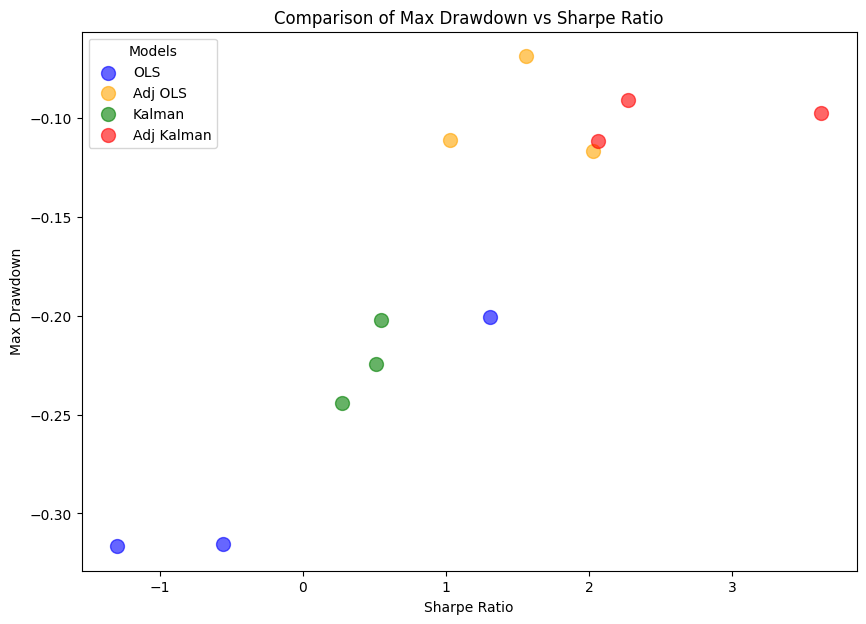

In [20]:
periods = ["Period 1", "Period 2", "Period 3"]
models = ["OLS", "Adj OLS", "Kalman", "Adj Kalman"]
colors = ['blue', 'orange', 'green', 'red']  # Fixed colors for each model

fig, ax = plt.subplots(figsize=(10, 7))  # Create a larger figure for clarity

for i, model in enumerate(models):
    sharpe_ratios = [results[period][model]["Sharpe Ratio"] for period in periods]
    max_drawdowns = [results[period][model]["Max Drawdown"] for period in periods]  # Use Max Drawdown data

    ax.scatter(sharpe_ratios, max_drawdowns, color=colors[i], s=100, label=model, alpha=0.6)

ax.set_xlabel('Sharpe Ratio')
ax.set_ylabel('Max Drawdown')
ax.set_title('Comparison of Max Drawdown vs Sharpe Ratio')
ax.legend(title='Models')

plt.show()
